In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = np.random.seed(0)


33
(23285,)


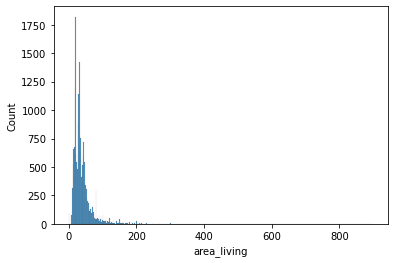

In [368]:
train_data_apartments = pd.read_csv("data/apartments_train.csv")
train_data_buildings = pd.read_csv("data/buildings_train.csv")

train_data = pd.merge(train_data_apartments, train_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
sns.histplot((train_data.area_living))
print(np.sum(train_data.price>np.exp(20)))
#train_data = train_data[train_data.price<np.exp(20)]
num_of_training_samples = train_data.shape[0]

y_train = (np.asarray(train_data.price))
print(y_train.shape)
train_data = train_data.drop("price", axis = 1)


test_data_apartments = pd.read_csv("data/apartments_test.csv")
test_data_buildings = pd.read_csv("data/buildings_test.csv")

test_data = pd.merge(test_data_apartments, test_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
test_ids = test_data.id

all_data = pd.concat([train_data, test_data])

In [369]:
def euclid_dist_from_center(lat, long):
    lat_city_center = 55.75
    long_city_center = 37.6

    return np.sqrt(np.power(np.abs(lat_city_center - lat), 2) + np.power(np.abs(long_city_center - long), 2))

In [370]:
# combining street and address to identify builidngs
all_data["street_and_address"] = all_data.street + " " + all_data.address
all_data["bathrooms"] = all_data.bathrooms_shared  + all_data.bathrooms_private
all_data["dist_from_city_center"] = euclid_dist_from_center(all_data.latitude, all_data.longitude)
#plt.scatter(np.log(y_train), all_data.dist_from_city_center[0:23285], s = 0.1)
all_data["balconies_and_loggias"] = all_data.balconies + all_data.loggias
all_data["no_windows"] = (~((np.asarray(all_data.windows_court)==1) | (np.asarray(all_data.windows_street)==1))).astype(int)



#all_data = all_data.drop(["bathrooms_shared", "bathrooms_private", "balconies", "loggias", "area_kitchen", "area_living", "id"], axis = 1)

all_data = all_data.drop(["address", "bathrooms_shared", "bathrooms_private", "balconies", "loggias", "id", "building_id",
"windows_court", "windows_street"], axis = 1)

print(len(all_data.keys()))


29


In [371]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating", "street_and_address"]
boolean_columns = ["new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"]
categorical_and_boolean_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating", "street_and_address"]
numerical_columns = ["area_total", "area_living", "area_kitchen", "floor", "rooms", "ceiling", "phones", "bathrooms", "balconies_and_loggias", "dist_from_city_center", "constructed", "stories", "latitude", "longitude"]
numerical_and_categorical_columns = ["area_total", "area_living", "area_kitchen", "floor", "rooms", "ceiling", "phones", "bathrooms", "balconies_and_loggias", "dist_from_city_center", "constructed", "stories", "seller", "layout", "condition", "building_id", "district", "material", "parking", "heating", "street_and_address", "latitude", "longitude"]

boolean_imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
all_data[boolean_columns] = boolean_imputer.fit_transform(all_data[boolean_columns])

string_encoder = LabelEncoder()
all_data["street_and_address"] = string_encoder.fit_transform(all_data.street_and_address)
print(np.unique(all_data.street_and_address))

all_data["street"] = string_encoder.fit_transform(all_data.street)


categorical_imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
all_data[categorical_columns] = boolean_imputer.fit_transform(all_data[categorical_columns])

numerical_imputer = IterativeImputer(missing_values = np.nan, random_state = 0)
all_data[numerical_columns] = numerical_imputer.fit_transform(all_data[numerical_columns])

all_data = all_data.drop(["garbage_chute", "heating", "phones", "elevator_service", "elevator_passenger", "new"], axis = 1)

#print(np.sum(np.isnan(all_data)))

[   0    1    2 ... 9719 9720 9721]


In [372]:

all_data.constructed -= 2000

all_data.area_total = np.log(all_data.area_total)

all_data["relative_story"] = all_data.floor/all_data.stories

train_data = all_data[0:num_of_training_samples]
test_data = all_data[num_of_training_samples:len(all_data)]

print(len(set([1,0])-set([1,0])))

print(len(set(train_data.street)-set(test_data.street)))

train_data.is_copy = False
test_data.is_copy = False

train_data["price"] = y_train.copy()
price_per_district = train_data.groupby("district").mean().price
area_per_district = train_data.groupby("district").mean().area_total
price_per_street = train_data.groupby("street").mean().price
area_per_street = train_data.groupby("street").mean().area_total

#train_data["price_per_sq_dist_cat"], bins = pd.qcut(train_data.dist_from_city_center, q = 200, retbins = True)
#test_data["price_per_sq_dist_cat"] = pd.cut(train_data.dist_from_city_center, bins = bins)


#price_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().price
#area_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().area_total

a = np.log(price_per_district/area_per_district)
#b = np.log(price_per_dist/area_per_dist)
c = np.log(price_per_street/area_per_street)

#print(b)
print(c)

#train_data = pd.concat([train_data, pd.DataFrame(columns = ["price_per_ring"])], axis = 1)
#test_data = pd.concat([test_data, pd.DataFrame(columns = ["price_per_ring"])], axis = 1)

print(train_data.head(2))
print(test_data.head(2))

for i in range(0, len(a.values)):
    train_data["district"].loc[train_data.district == i] = a[i].copy()
    test_data["district"].loc[test_data.district == i] = a[i].copy()

#train_data["price_per_ring"] = train_data["price_per_sq_dist_cat"].map(b).astype(float)
#test_data["price_per_ring"] = test_data["price_per_sq_dist_cat"].map(b).astype(float)

train_data["street"] = train_data["street"].map(c).astype(float)
test_data["street"] = test_data["street"].map(c).astype(float)

train_data = train_data.drop(["price"], axis = 1)
train_data = train_data.drop(["latitude", "longitude"], axis = 1)
test_data = test_data.drop(["latitude", "longitude"], axis = 1)

street_imputer = IterativeImputer(missing_values = np.nan, random_state = 0)
street_imputer.fit(pd.concat([train_data, test_data], axis = 0))
print("alskfm", np.sum(np.sum(np.isnan(test_data))))
test_data = street_imputer.transform(test_data)
print("aojfn", np.sum(np.sum(np.isnan(test_data))))




#print(train_data.head(2))
#print(test_data.head(2))


0
678
street
0       14.621280
2       15.903661
3       15.958195
6       14.677557
7       14.648890
          ...    
1847    15.161709
1848    14.580419
1849    14.505675
1850    14.817745
1851    13.926014
Length: 1682, dtype: float64
   seller  area_total  area_kitchen  area_living  floor  rooms  layout  \
0     3.0    4.080922          12.5         31.0    2.0    2.0     1.0   
1     3.0    4.477337          14.2         48.0   18.0    3.0     1.0   

    ceiling  condition   latitude  ...  stories  elevator_without  parking  \
0  2.650000        1.0  55.544046  ...      9.0               0.0      1.0   
1  3.560078        3.0  55.861282  ...     25.0               0.0      1.0   

   street_and_address  bathrooms  dist_from_city_center  \
0              1271.0        2.0               0.239348   
1              9050.0        2.0               0.129713   

   balconies_and_loggias  no_windows  relative_story       price  
0               1.161594           0        0.222222   71

C:\Users\Moritz\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Moritz\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Moritz\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

alskfm 762
aojfn 0


In [373]:
from tensorflow.keras.losses import mean_squared_logarithmic_error
from tensorflow.keras.backend import sqrt

def root_mean_squared_log_error(y_true, y_pred):
    return sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [374]:
from sklearn.model_selection import train_test_split

print(len(train_data))
x_train, x_val, y_train, y_val = train_test_split(train_data, y_train, train_size = 0.8, random_state = 1)
y_train = np.log(y_train)

print(np.sum(y_train))
print(len(x_train))


23285
306155.4135451964
18628


In [375]:

from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

In [376]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

model_xgb = XGBRegressor(n_estimators=1500, max_depth=4, n_jobs=-1, booster='gbtree')
trans_xgb = TransformedTargetRegressor(regressor=model_xgb, func=np.log1p, inverse_func=np.expm1)

model_cat = CatBoostRegressor(iterations=2000,  depth=7, learning_rate=0.15, l2_leaf_reg=0.45, silent=True)
trans_cat = TransformedTargetRegressor(regressor=model_cat, func=np.log1p, inverse_func=np.expm1)

model_knn_256 = KNeighborsRegressor(n_neighbors=256)
model_knn_512 = KNeighborsRegressor(n_neighbors=512)
model_knn_1024 = KNeighborsRegressor(n_neighbors=1024, p=1, n_jobs=-1)

final_model = RidgeCV()


base_learners = [
    ('xgb_tree', trans_xgb),
    ("random_forest", model2),
    # ('knn_256', model3),
    # ('knn_512', model4),
    # ('knn_1024', model5),
    ('catboost', trans_cat)
]

stacking_model = StackingRegressor(estimators=base_learners, n_jobs=-1, final_estimator=final_model)

In [377]:
stacking_model.fit(x_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('xgb_tree',
                               TransformedTargetRegressor(check_inverse=True,
                                                          func=<ufunc 'log1p'>,
                                                          inverse_func=<ufunc 'expm1'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster='gbtree',
                                                                                 colsample_bylevel=None,
                                                                                 colsample_bynode=None,
                                                                                 colsample_bytree=None,
                                                                                 gamma=None,
                                                                                 

In [378]:
predictions_val = np.exp(stacking_model.predict(x_val))

tf.Tensor(0.12082115283474366, shape=(), dtype=float64)
seller                   0.000569
area_total               0.680068
area_kitchen             0.002591
area_living              0.003863
floor                    0.002174
rooms                    0.000781
layout                   0.000150
ceiling                  0.002112
condition                0.002068
district                 0.002406
street                   0.276486
constructed              0.004392
material                 0.000661
stories                  0.003078
elevator_without         0.000332
parking                  0.000546
street_and_address       0.002942
bathrooms                0.001046
dist_from_city_center    0.008792
balconies_and_loggias    0.001459
no_windows               0.000267
relative_story           0.003218
dtype: float64


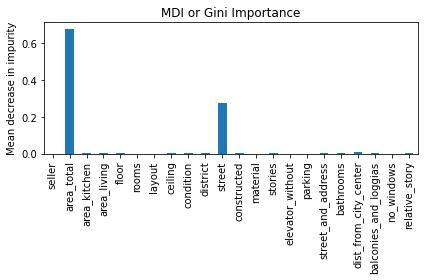

In [380]:
print(root_mean_squared_log_error(y_val, predictions_val))
#importances = stacking_model.feature_importances_
forest_importances = pd.Series(importances, index=train_data.columns)

print(forest_importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [381]:
prediction = stacking_model.predict(test_data)
prediction = np.exp(prediction)
submission = pd.DataFrame()
submission['id'] = test_ids
submission["price_prediction"] = prediction
submission.to_csv('simple_nn_submission.csv', index=False)